## Imports

In [2]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [3]:
from pymongo import MongoClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import string

In [4]:
from sshtunnel import SSHTunnelForwarder
from getpass import getpass

## Connnection

In [5]:
MONGO_HOST = "flask01.network.ncf.edu"
MONGO_DB = "hfmil"
MONGO_USER = input("Enter your username: ")
MONGO_PASS = getpass("Enter your password: ")

Enter your username: mtweed
Enter your password: ········


In [6]:
server = SSHTunnelForwarder(
    MONGO_HOST,
    ssh_username=MONGO_USER,
    ssh_password=MONGO_PASS,
    remote_bind_address=('127.0.0.1', 27017)
)

In [7]:
server.start()

In [8]:
client = MongoClient('127.0.0.1', server.local_bind_port)

In [9]:
db = client[MONGO_DB]

In [10]:
db.list_collection_names()

['hfi19', 'system.indexes', 'gdp', 'conflicts', 'exp_prop', 'mil_exp']

## Conflict Data

In [17]:
cur = db.conflicts.find({},{'_id':0,'location':1,'side_a':1,'side_b':1,'year':1, 'start_date':1, 'ep_end_date':1, 'region':1})

In [19]:
df = pd.DataFrame()
for i in range(cur.count()):
    temp = cur.next()
    df = df.append(temp, ignore_index=True)

In [20]:
df

,ep_end_date,location,region,side_a,side_b,start_date,year
0,2012-12-21,India,3,Government of India,GNLA,1997-05-29,2012.0
1,2014-11-27,India,3,Government of India,GNLA,1997-05-29,2014.0
2,1967-06-10,"Egypt, Israel",2,Government of Egypt,Government of Israel,1967-06-05,1967.0
3,NaN,"Egypt, Israel",2,Government of Egypt,Government of Israel,1967-06-05,1969.0
4,1970-08-07,"Egypt, Israel",2,Government of Egypt,Government of Israel,1967-06-05,1970.0
...,...,...,...,...,...,...,...
2443,NaN,Myanmar (Burma),3,Government of Myanmar (Burma),LNUP,1973-01-11,1980.0
2444,NaN,Myanmar (Burma),3,Government of Myanmar (Burma),LNUP,1973-01-11,1981.0
2445,1982-12-31,Myanmar (Burma),3,Government of Myanmar (Burma),LNUP,1973-01-11,1982.0
2446,NaN,Mauritania,4,Government of Mauritania,AQIM,2008-09-15,2010.0


In [21]:
# cleans the text to isolate country name
def cleanSide(side):
    nopunc = [c for c in side if c not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in ['government','of','the']]

In [22]:
df['side_a'] = df['side_a'].apply(cleanSide)

In [23]:
df['side_b'] = df['side_b'].apply(cleanSide)

In [24]:
df['location'] = df['location'].apply(cleanSide)

In [25]:
df.head()

,ep_end_date,location,region,side_a,side_b,start_date,year
0,2012-12-21,[India],3,[India],[GNLA],1997-05-29,2012.0
1,2014-11-27,[India],3,[India],[GNLA],1997-05-29,2014.0
2,1967-06-10,"[Egypt, Israel]",2,[Egypt],[Israel],1967-06-05,1967.0
3,NaN,"[Egypt, Israel]",2,[Egypt],[Israel],1967-06-05,1969.0
4,1970-08-07,"[Egypt, Israel]",2,[Egypt],[Israel],1967-06-05,1970.0


## Connecting Conflicts and HFI

In [26]:
cur = db.hfi19.find({},{'_id':0,'ISO_code':1,'countries':1,'hf_score':1, 'year':1})

In [27]:
hfDf = pd.DataFrame()
for i in range(cur.count()):
    temp = cur.next()
    hfDf = hfDf.append(temp, ignore_index=True)

In [28]:
hfDf = hfDf.rename({'countries':'country'}, axis = 1)

In [29]:
hfDf.head()

,ISO_code,country,hf_score,year
0,ALB,Albania,7.84,2017.0
1,GIN,Guinea,NaN,2010.0
2,LAO,Laos,NaN,2010.0
3,LBR,Liberia,NaN,2010.0
4,LBY,Libya,NaN,2010.0


## Query conflicts side A

In [30]:
def getConflicts(country):
    cur = db.conflicts.find({'side_a': {'$regex': country, '$options': 'i'}},{'_id':0, 'conflict_id':1})
    conflicts = set()
    while True:
        try:
            temp = cur.next()
            if len(temp) > 0:
                conflicts.add(temp['conflict_id'])
        except:
            break
    return list(conflicts)

In [31]:
def getNumConflicts(country):
    cur = db.conflicts.find({'side_a': {'$regex': country, '$options': 'i'}},{'_id':0, 'conflict_id':1})
    conflicts = set()
    while True:
        try:
            temp = cur.next()
            if len(temp) > 0:
                conflicts.add(temp['conflict_id'])
        except:
            break
    return len(list(conflicts))

In [32]:
def getNumOp(country):
    cur = db.conflicts.find({'side_a': {'$regex': country, '$options': 'i'}},{'_id':0, 'conflict_id':1})
    conflicts = []
    while True:
        try:
            temp = cur.next()
            if len(temp) > 0:
                conflicts.append(temp['conflict_id'])
        except:
            break
    return len(conflicts)

In [33]:
hfDf['num_conflicts_side_A'] = hfDf['country'].apply(getNumConflicts)

In [34]:
hfDf['conflicts_side_A'] = hfDf['country'].apply(getConflicts)

In [35]:
hfDf['num_ops_side_A'] = hfDf['country'].apply(getNumOp)

In [36]:
hfDf.sort_values(by = "num_conflicts_side_A", ascending = False)

,ISO_code,country,hf_score,year,num_conflicts_side_A,conflicts_side_A,num_ops_side_A
1206,IND,India,6.75,2010.0,13,"[227, 421, 296, 364, 365, 11342, 335, 347, 434...",201
745,IND,India,6.69,2013.0,13,"[227, 421, 296, 364, 365, 11342, 335, 347, 434...",201
900,IND,India,6.78,2012.0,13,"[227, 421, 296, 364, 365, 11342, 335, 347, 434...",201
82,IND,India,6.64,2017.0,13,"[227, 421, 296, 364, 365, 11342, 335, 347, 434...",201
586,IND,India,6.34,2014.0,13,"[227, 421, 296, 364, 365, 11342, 335, 347, 434...",201
...,...,...,...,...,...,...,...
1089,NZL,New Zealand,8.82,2011.0,0,[],0
488,SYC,Seychelles,7.53,2015.0,0,[],0
1094,NOR,Norway,8.49,2011.0,0,[],0
481,QAT,Qatar,6.32,2015.0,0,[],0


## Conflicts per country side A
(for countries with more than one conflict)

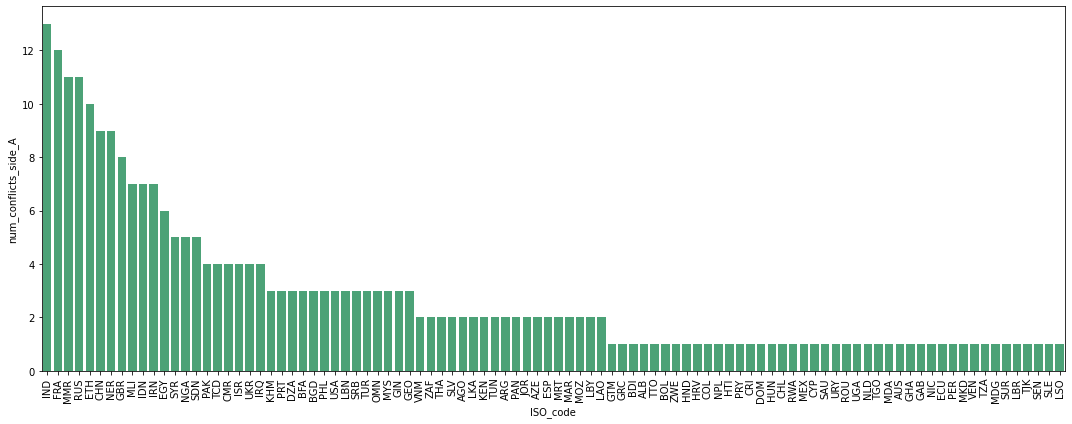

In [37]:
plt.figure(figsize=(15,6))
sns.barplot(data = hfDf[hfDf['num_conflicts_side_A'] > 0].sort_values('num_conflicts_side_A',ascending=False), 
            x = 'ISO_code', y = 'num_conflicts_side_A',
           color = '#3eb077')
plt.xticks(rotation = 90)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tight_layout(h_pad=2)
plt.savefig('num_conflicts_side_A.png')

## Operation per country side A
(most conflicts are composed of more than one operation)

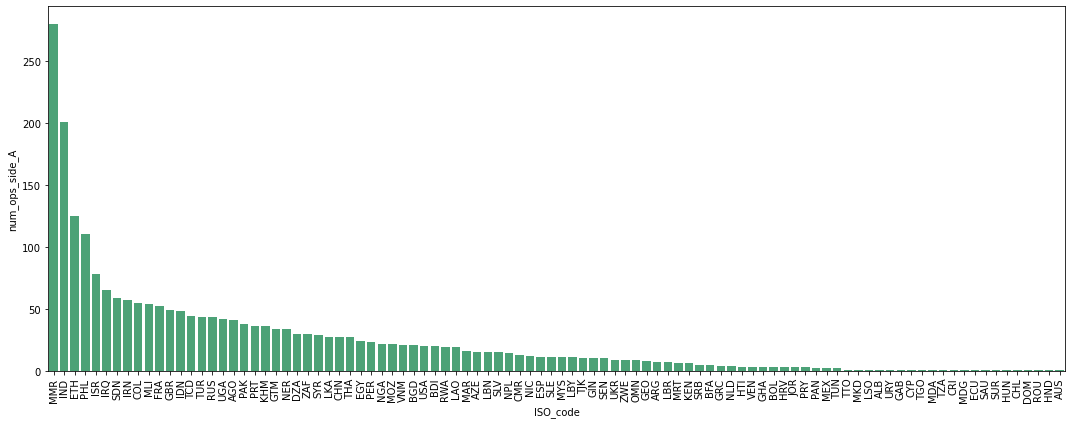

In [38]:
plt.figure(figsize=(15,6))
sns.barplot(data = hfDf[hfDf['num_ops_side_A'] > 0].sort_values('num_ops_side_A',ascending=False), 
            x = 'ISO_code', y = 'num_ops_side_A',
           color = '#3eb077')
plt.xticks(rotation = 90)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tight_layout(h_pad=2)
plt.savefig('num_ops_side_A.png')

## HF score vs. number of conflicts side A

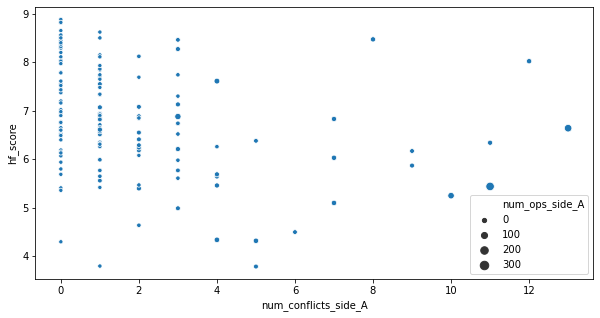

In [39]:
d17 = hfDf[hfDf.year == 2017]
plt.figure(figsize=(10,5))
sns.scatterplot(data=d17, x = 'num_conflicts_side_A', y = 'hf_score', size='num_ops_side_A')

## Operations per country choropleth
(where country is side A)

In [40]:
p = px.choropleth(data_frame=hfDf, locations='ISO_code', color= 'num_ops_side_A')
p.show()

## Query conflicts side B

In [41]:
def getConflicts(country):
    cur = db.conflicts.find({'side_b': {'$regex': country, '$options': 'i'}},{'_id':0, 'conflict_id':1})
    conflicts = set()
    while True:
        try:
            temp = cur.next()
            if len(temp) > 0:
                conflicts.add(temp['conflict_id'])
        except:
            break
    return list(conflicts)

In [42]:
def getNumConflicts(country):
    cur = db.conflicts.find({'side_b': {'$regex': country, '$options': 'i'}},{'_id':0, 'conflict_id':1})
    conflicts = set()
    while True:
        try:
            temp = cur.next()
            if len(temp) > 0:
                conflicts.add(temp['conflict_id'])
        except:
            break
    return len(list(conflicts))

In [43]:
def getNumOp(country):
    cur = db.conflicts.find({'side_b': {'$regex': country, '$options': 'i'}},{'_id':0, 'conflict_id':1})
    conflicts = []
    while True:
        try:
            temp = cur.next()
            if len(temp) > 0:
                conflicts.append(temp['conflict_id'])
        except:
            break
    return len(conflicts)

In [44]:
hfDf['num_conflicts_side_B'] = hfDf['country'].apply(getNumConflicts)

In [45]:
hfDf['conflicts_side_B'] = hfDf['country'].apply(getConflicts)

In [46]:
hfDf['num_ops_side_B'] = hfDf['country'].apply(getNumOp)

In [47]:
hfDf.sort_values(by = "num_conflicts_side_B", ascending = False)

,ISO_code,country,hf_score,year,num_conflicts_side_A,conflicts_side_A,num_ops_side_A,num_conflicts_side_B,conflicts_side_B,num_ops_side_B
1288,GBR,United Kingdom,8.51,2010.0,8,"[420, 229, 207, 241, 273, 248, 315, 286]",49,5,"[239, 252, 215, 346, 13692]",6
671,GBR,United Kingdom,8.56,2014.0,8,"[420, 229, 207, 241, 273, 248, 315, 286]",49,5,"[239, 252, 215, 346, 13692]",6
512,GBR,United Kingdom,8.55,2015.0,8,"[420, 229, 207, 241, 273, 248, 315, 286]",49,5,"[239, 252, 215, 346, 13692]",6
828,GBR,United Kingdom,8.53,2013.0,8,"[420, 229, 207, 241, 273, 248, 315, 286]",49,5,"[239, 252, 215, 346, 13692]",6
340,GBR,United Kingdom,8.52,2016.0,8,"[420, 229, 207, 241, 273, 248, 315, 286]",49,5,"[239, 252, 215, 346, 13692]",6
...,...,...,...,...,...,...,...,...,...,...
613,MRT,Mauritania,5.38,2014.0,2,"[442, 428]",6,0,[],0
612,MLT,Malta,8.43,2014.0,0,[],0,0,[],0
609,MWI,Malawi,6.56,2014.0,0,[],0,0,[],0
608,MDG,Madagascar,6.75,2014.0,1,[310],1,0,[],0


## Conflicts per country side B
(for countries with more than one conflict)

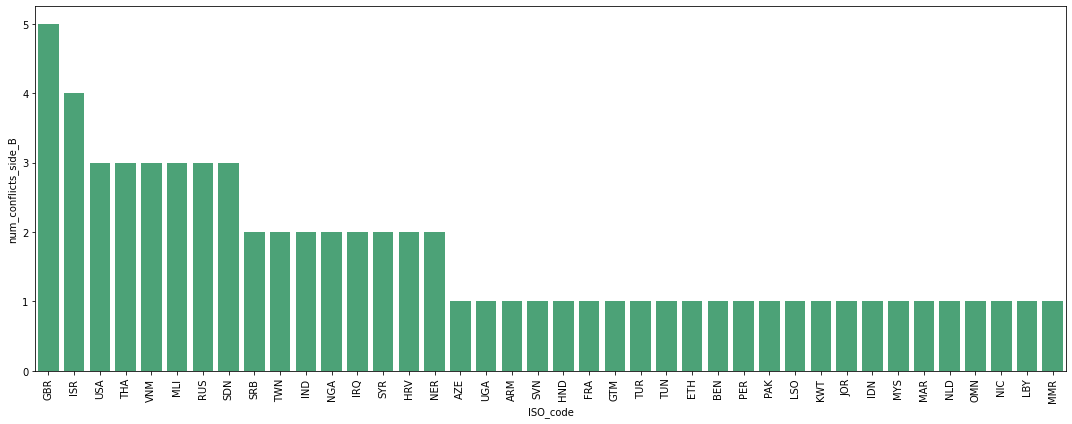

In [48]:
plt.figure(figsize=(15,6))
sns.barplot(data = hfDf[hfDf['num_conflicts_side_B'] > 0].sort_values('num_conflicts_side_B',ascending=False), 
            x = 'ISO_code', y = 'num_conflicts_side_B',
           color = '#3eb077')
plt.xticks(rotation = 90)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tight_layout(h_pad=2)
plt.savefig('num_conflicts_side_B.png')

## Operation per country side B
(most conflicts are composed of more than one operation)

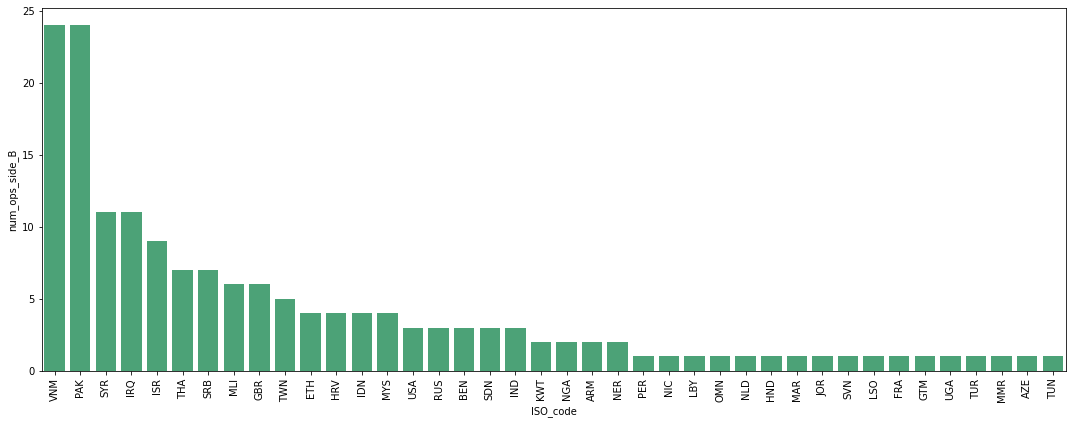

In [49]:
plt.figure(figsize=(15,6))
sns.barplot(data = hfDf[hfDf['num_ops_side_B'] > 0].sort_values('num_ops_side_B',ascending=False), 
            x = 'ISO_code', y = 'num_ops_side_B',
           color = '#3eb077')
plt.xticks(rotation = 90)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tight_layout(h_pad=2)
plt.savefig('num_ops_side_B.png')

## Adding military expenditure proportion

In [52]:
years = list(hfDf.year.unique())
years

[2017.0,
 2010.0,
 2011.0,
 2012.0,
 2016.0,
 2015.0,
 2014.0,
 2013.0,
 2009.0,
 2008.0]

In [53]:
tempdf = pd.DataFrame()
for year in years:
    codes = hfDf.loc[hfDf['year']==year,'ISO_code']
    for code in codes:
        prop = db.exp_prop.find_one({'Code':code},{'_id':0, str(int(year)):1})
        try:
            prop = list(prop.values())[0]
        except:
            prop = None
        tempdf = tempdf.append({'ISO_code':code, 'year':year,'prop_gdp':prop}, 
                               ignore_index=True)

In [54]:
tempdf

,ISO_code,prop_gdp,year
0,ALB,0.0110896,2017.0
1,DZA,0.0601792,2017.0
2,AGO,0.0250801,2017.0
3,ARG,0.00849491,2017.0
4,ARM,0.0384829,2017.0
...,...,...,...
1615,AUS,0.0176785,2008.0
1616,DNK,0.01355,2008.0
1617,CHE,0.00739309,2008.0
1618,NZL,0.0124634,2008.0


In [55]:
hfDf = hfDf.merge(tempdf, on = ['ISO_code', 'year'])

In [56]:
hfDf

,ISO_code,country,hf_score,year,num_conflicts_side_A,conflicts_side_A,num_ops_side_A,num_conflicts_side_B,conflicts_side_B,num_ops_side_B,prop_gdp
0,ALB,Albania,7.84,2017.0,1,[215],1,0,[],0,0.0110896
1,GIN,Guinea,NaN,2010.0,3,"[369, 410, 307]",10,0,[],0,None
2,LAO,Laos,NaN,2010.0,2,"[356, 262]",19,0,[],0,0.00215444
3,LBR,Liberia,NaN,2010.0,1,[341],7,0,[],0,0.00423323
4,LBY,Libya,NaN,2010.0,2,"[11346, 13694]",11,1,[361],1,None
...,...,...,...,...,...,...,...,...,...,...,...
1615,AUS,Australia,8.73,2008.0,1,[420],1,0,[],0,0.0176785
1616,DNK,Denmark,8.73,2008.0,0,[],0,0,[],0,0.01355
1617,CHE,Switzerland,8.83,2008.0,0,[],0,0,[],0,0.00739309
1618,NZL,New Zealand,8.94,2008.0,0,[],0,0,[],0,0.0124634


In [57]:
hfDf.describe()

,hf_score,year,num_conflicts_side_A,num_ops_side_A,num_conflicts_side_B,num_ops_side_B
count,1540.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000
mean,6.978214,2012.500000,1.666667,14.234568,0.413580,1.024691
std,1.056239,2.873168,2.517389,32.565901,0.872651,3.184565
min,3.690000,2008.000000,0.000000,0.000000,0.000000,0.000000
25%,6.280000,2010.000000,0.000000,0.000000,0.000000,0.000000
50%,6.900000,2012.500000,1.000000,1.000000,0.000000,0.000000
75%,7.880000,2015.000000,2.000000,15.000000,0.000000,0.000000
max,9.120000,2017.000000,13.000000,280.000000,5.000000,24.000000


## HF score per year

In [58]:
fig = go.Figure()

years = [year for year in hfDf.year.unique()]

for year in years:
    fig.add_trace(
        go.Choropleth(
            z = hfDf.loc[hfDf['year']==year,'hf_score'],
            locations = hfDf.loc[hfDf['year']==year,'ISO_code'],
            zmax = 9.12,
            zmin = 3.5))

fig.data[9].visible = True


steps = []
for i in range(len(years)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "HF scores for the year: " + str(int(years[i]))}],
        label = str(int(years[i]))
    )
    step["args"][0]["visible"][i] = True
    steps.append(step)
    
sliders = [dict(
    active=10,
    currentvalue={"prefix": "Year: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

fig.show()

 ## Military Expenditure Per Year

In [59]:
fig = go.Figure()

years = [year for year in hfDf.year.unique()]

for year in years:
    fig.add_trace(
        go.Choropleth(
            z = hfDf.loc[hfDf['year']==year,'prop_gdp'],
            locations = hfDf.loc[hfDf['year']==year,'ISO_code'],
            zmax = 0.1,
            zmin = 0))

fig.data[9].visible = True


steps = []
for i in range(len(years)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Military expenditure as proportion of gdp for the year: " + str(int(years[i]))}],
        label = str(int(years[i]))
    )
    step["args"][0]["visible"][i] = True
    steps.append(step)
    
sliders = [dict(
    active=10,
    currentvalue={"prefix": "Year: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

fig.show()

## Conflict info

In [60]:
ic_df = hfDf.loc[hfDf.year == 2017,['ISO_code', 'conflicts_side_A', 'conflicts_side_B']]

In [61]:
con_info = pd.DataFrame()
for i in range(len(ic_df)):
    temp = ic_df.iloc[i,:]
    conflicts = temp['conflicts_side_A']
    conflicts.append(temp['conflicts_side_B'])
    code = temp['ISO_code']
    for con in conflicts:
        cur = db.conflicts.find({'conflict_id':con}, 
                               {'_id':0, 'location':1,'side_a':1,
                                'side_b':1, 'year':1,'intensity_level':1,
                                'cumulative_intensity':1,
                                'start_date':1,'ep_end_date':1
                               })
        while True:
            try:
                nxt = cur.next()
                nxt['ISO_code'] = code
                nxt['conflict_id'] = con
                con_info = con_info.append(nxt, ignore_index = True)
            except:
                break

In [62]:
con_info.describe()

,conflict_id,cumulative_intensity,intensity_level,year
count,2306.000000,2306.000000,2306.000000,2306.000000
mean,1105.450130,0.713356,1.246314,1988.146574
std,3111.952954,0.452292,0.430957,19.645828
min,200.000000,0.000000,1.000000,1946.000000
25%,247.250000,0.000000,1.000000,1974.000000
50%,300.000000,1.000000,1.000000,1989.000000
75%,354.000000,1.000000,1.000000,2004.000000
max,14935.000000,1.000000,2.000000,2019.000000


In [63]:
con_info.head()

,ISO_code,conflict_id,cumulative_intensity,ep_end_date,intensity_level,location,side_a,side_b,start_date,year
0,ALB,215.0,0.0,1946-12-31,1.0,"Albania, United Kingdom",Government of Albania,Government of United Kingdom,1946-10-22,1946.0
1,DZA,13721.0,0.0,2015-05-20,1.0,Algeria,Government of Algeria,IS,2014-10-10,2015.0
2,DZA,386.0,0.0,NaN,1.0,Algeria,Government of Algeria,Takfir wa'l Hijra,1985-08-27,1991.0
3,DZA,386.0,0.0,NaN,1.0,Algeria,Government of Algeria,AIS,1985-08-27,1992.0
4,DZA,386.0,1.0,NaN,1.0,Algeria,Government of Algeria,"AIS, GIA",1985-08-27,1993.0
